In [1]:
# imports
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, case
from sqlalchemy.orm import mapper, create_session
from sqlalchemy.sql import and_, or_, not_, select, func
import sqlalchemy.types as types
from sqlalchemy.ext.automap import automap_base
import csv
import numpy as np
import matplotlib.pyplot as plt
import numbers
import re
import createDBfromCSV_NODC
from os.path import isfile
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
%matplotlib inline

In [2]:
# definitions
file1='/ocean/eolson/MEOPAR/obs/WODSelect_46_52_m130_m122_nitrate/ocldb1452624712.14684.OSD.csv'
outfile='/ocean/eolson/MEOPAR/obs/WODSelect_46_52_m130_m122_nitrate/WOD'

In [3]:
# if outfile.sqlite does not exist, run script to create it
if not isfile(outfile+'.sqlite'):
    createDBfromCSV_NODC.main( file1, outfile)
    print('done')
else:
    print('file exists')

file exists


In [4]:
# prepare to reflect DB structure
Base = automap_base()

# engine, suppose it has two tables 'user' and 'address' set up
engine = create_engine('sqlite:///' + outfile + '.sqlite')

# reflect the tables
Base.prepare(engine, reflect=True)

# mapped classes are now created with names by default
# matching that of the table name.
Stat=Base.classes.stationTBL
Prof=Base.classes.profileTBL

In [5]:
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [6]:
# map:
width = 650000; lon_0 = -126; lat_0 = 49.2
plt.figure(figsize=(10,10))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary()
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(40,60,2))
m.drawmeridians(np.arange(-130,-110,2))
plt.title('Salish Sea Region')

q=session.query(Stat.Latitude, Stat.Longitude, Stat.Year, Stat.Month, Stat.Day, Prof.Depth, Prof.Ammonia).\
        select_from(Prof).join(Stat,Stat.CastID==Prof.CastID).filter(and_(
            Prof.Ammonia!=None,
            Stat.Latitude!=None,
            Stat.Longitude!=None,
            Stat.Month!=None))
for Lat, Lon, Y, M, D, P, N in q.all():
    if Lon>0:
        Lon=-Lon
    xpt, ypt = m(Lon, Lat)
    m.plot([xpt],[ypt],'r.')

NameError: name 'Basemap' is not defined

/home/eolson/anaconda3/lib/python3.4/site-packages/sqlalchemy/sql/sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


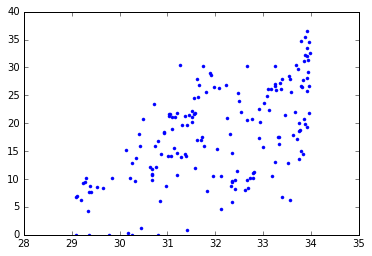

In [6]:
data2=session.query(Prof.Salinity, Prof.Nitrate).join(Stat, Stat.CastID==Prof.CastID).filter(
    and_(
        Stat.Latitude > 48.3,
        Stat.Latitude < 48.8,
        Stat.Longitude < -124.3,
        Stat.Longitude > -125.2,
        ))
NO=[]
S=[]
for m, n in data2.all():
    S.append(m)
    NO.append(n)
    
plt.axis([28,35,0,40])
plt.plot(S,NO,'.')

In [7]:
qJDF=session.query(Stat, Prof).join(Prof, Stat.CastID==Prof.CastID).filter(
    and_(
        Stat.Latitude > 48.3,
        Stat.Latitude < 48.8,
        Stat.Longitude < -124.3,
        Stat.Longitude > -125.2,
        )).subquery()

/home/eolson/anaconda3/lib/python3.4/site-packages/sqlalchemy/sql/base.py:530: SAWarning: Column 'CastID' on table <sqlalchemy.sql.selectable.Select at 0x7fad2109a3c8; Select object> being replaced by Column('CastID', INTEGER(), table=<Select object>), which has the same key.  Consider use_labels for select() statements.
  (key, getattr(existing, 'table', None), value))


In [8]:
q2=session.query(qJDF.c.Year, func.count(qJDF.c.Year)).group_by(qJDF.c.Year).all()
print(q2)

[(1961, 100), (1962, 55), (1963, 13), (1964, 15), (1971, 15), (1972, 1)]


/home/eolson/anaconda3/lib/python3.4/site-packages/sqlalchemy/sql/base.py:530: SAWarning: Column 'CastID' on table <sqlalchemy.sql.selectable.Alias at 0x7fad23158dd8; %(140381594684888 anon)s> being replaced by Column('CastID', INTEGER(), table=<%(140381594684888 anon)s>), which has the same key.  Consider use_labels for select() statements.
  (key, getattr(existing, 'table', None), value))


In [11]:
q3=session.query(Stat.Year, func.count(Stat.Year)).group_by(Stat.Year).all()
print(q3)

[(1931, 10), (1932, 39), (1958, 5), (1961, 80), (1962, 65), (1963, 117), (1964, 109), (1965, 208), (1966, 142), (1967, 20), (1968, 85), (1969, 40), (1970, 56), (1971, 18), (1972, 14), (1973, 34), (1974, 8), (1982, 58), (1985, 9), (1993, 3), (1994, 2), (1995, 8), (2007, 22)]


In [9]:
s=select([prof.c.OBS_YEAR, prof.c.OBS_MONTH, prof.c.DEPTH_PRESS, prof.c.PSAL, prof.c.SSAL, prof.c.NTRA]).where(
    and_(
        prof.c.LATITUDE > 48.3,
        prof.c.LATITUDE < 48.8,
        prof.c.LONGITUDE < 125.2,
        prof.c.LONGITUDE > 124.3,
        prof.c.NTRA != 'NaN',
        or_(
            prof.c.PSAL !='NaN',
            prof.c.SSAL !='NaN'
            )
        ))
results=conn.execute(s).fetchall()
print(results[1])

NameError: name 'prof' is not defined

In [ ]:
conn.close()
engine.dispose()